In [1]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "DeepLearning/DeepLearningProject/Project/FullCNNversion/Train"
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
assert GOOGLE_DRIVE_PATH_AFTER_MYDRIVE is not None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['27gIpN.jpg', '29Pkqp.jpg', '9KkoOf.jpg', '1PFDZe.jpg', '11Se02.jpg', '8X0jDX.jpg', '8oZO2i.jpg', '8ntGqA.jpg', '0qADtP.jpg', '30gdlQ.jpg']


In [4]:
# Get images
X = []
for filename in os.listdir(GOOGLE_DRIVE_PATH):
    X.append(img_to_array(load_img(os.path.join(GOOGLE_DRIVE_PATH, filename))))
X = np.array(X, dtype=float)

# Set up train and test data
split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

In [5]:
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse')

In [6]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model
tensorboard = TensorBoard(log_dir="output/first_run")
model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard], epochs=1, steps_per_epoch=10)

<ipython-input-6-e27311459831>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard], epochs=1, steps_per_epoch=10)


10/10 [==============================] - 113s 11s/step - loss: 0.9170


In [7]:
# Save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [8]:
# Test images
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(model.evaluate(Xtest, Ytest, batch_size=batch_size))

1/1 [==============================] - 0s 485ms/step - loss: 0.1772
0.17716826498508453


In [9]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "DeepLearning/DeepLearningProject/Project/FullCNNversion/Test"
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
assert GOOGLE_DRIVE_PATH_AFTER_MYDRIVE is not None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['7Vizcm.jpg', '0yTHvf.jpg', '9KfZez.jpg', '4r3yxj.jpg', '3YFtxe.jpg', '6v14hm.jpg', '0fAtAB.jpg', '1QejlL 4.11.06 PM.jpg']


In [10]:
import os
import imageio
import numpy as np
from keras.preprocessing.image import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb

# Assuming GOOGLE_DRIVE_PATH is defined earlier in your code

color_me = []
for filename in os.listdir(GOOGLE_DRIVE_PATH):
    color_me.append(img_to_array(load_img(os.path.join(GOOGLE_DRIVE_PATH, filename))))
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:, :, :, 0]
color_me = color_me.reshape(color_me.shape + (1,))

# Test model
output = model.predict(color_me)
print("Output shape:", output.shape)
print("Output data type:", output.dtype)

# Create the 'result' directory if it doesn't exist
result_dir = 'DeepLearning/DeepLearningProject/Project/FullCNNversion/Betaresult'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

# Output colorizations
for i in range(len(output)):
    # Create LAB image with original L channel and colorized A and B channels
    lab_output = np.zeros((256, 256, 3))
    lab_output[:, :, 0] = color_me[i][:, :, 0]  # Original L channel
    lab_output[:, :, 1:] = output[i]  # Colorized A and B channels

    # Convert LAB image to RGB
    rgb_output = lab2rgb(lab_output)

    # Save the image
    imageio.imwrite(os.path.join(result_dir, "img_" + str(i) + ".png"), (rgb_output * 255).astype(np.uint8))


1/1 [==============================] - 4s 4s/step
Output shape: (8, 256, 256, 2)
Output data type: float32


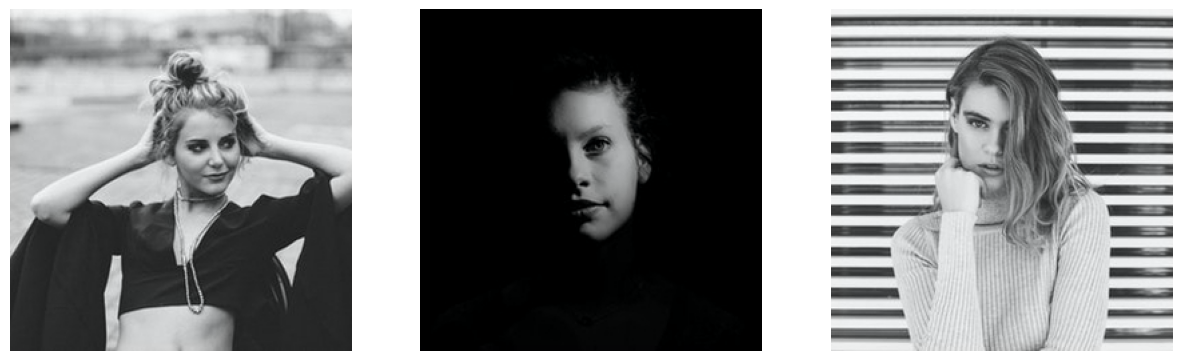

In [11]:
import matplotlib.pyplot as plt

# Display some of the result images
num_images_to_display = 3

fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

# Loop through some of the result images and display them
for i in range(num_images_to_display):
    # Load the image
    result_image_path = os.path.join(result_dir, f"img_{i}.png")
    result_image = plt.imread(result_image_path)

    # Display the image
    axes[i].imshow(result_image)
    axes[i].axis('off')

plt.show()

In [12]:
mse = model.evaluate(Xtest, Ytest, batch_size=batch_size)
print("Mean Squared Error (MSE):", mse)

1/1 [==============================] - 1s 605ms/step - loss: 0.1772
Mean Squared Error (MSE): 0.17716826498508453


In [18]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100  # Images are identical
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Calculate PSNR for each image
psnr_values = [psnr(Ytest[i], predicted_images[i]) for i in range(len(Ytest))]
average_psnr = np.mean(psnr_values)
print("Average PSNR:", average_psnr)


Average PSNR: 15.170868321853305
